In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio import *
from rasterio.plot import show
from pyspatialml import Raster
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [2]:
predictors = pd.read_csv("out_data/forest_data_poland_lucas.csv", sep=" ",  index_col=False, na_values = 48,
                         header = None)
pd.set_option('display.max_columns',None)


Better variable names

In [3]:
predictors_names = pd.read_csv("out_data/available_features_names.csv", sep=",",  index_col=False)
predictors.columns = predictors_names.name.tolist()
predictors.tail(5)

ValueError: Length mismatch: Expected axis has 22 elements, new values have 21 elements

In [9]:
pred_sel = ['GLAD_mean100m', 'JAXA_mean', 'C-GLOPS_mode', 'CLC10m_mean', 'C-GLOPS_mean', 'JAXA_q1', 'C-GLOPS_median'  ]
predictors = predictors[pred_sel]


Now the left hand side

In [10]:
outcome = pd.read_csv("out_data/LUCAS/LUCAS_locations.csv", sep=",",  index_col=False)
outcome.tail(5)

,X,Y,LC1,LC1_PERC,forest
23079,5.278000e+06,3.114000e+06,C22,100,1
23080,5.278000e+06,3.136000e+06,B11,100,0
23081,5.294000e+06,3.150000e+06,C10,100,1
23082,5.294000e+06,3.172000e+06,B11,92,0
23083,5.286000e+06,3.116000e+06,Bx1,98,0


In [ ]:
print (len(outcome))
print (len(predictors))

Split the Dataset

In [12]:
X    = predictors
Y    = outcome.iloc[:,4].to_frame()
feat = predictors.columns.values
print(X.shape)
print(Y.shape)
print(type(X))
print(type(Y))

(23084, 7)
(23084, 1)
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


There are a handful of NAs

In [13]:
na_rows = X.apply(lambda x: np.any(pd.isna(x)), axis=1)
result = np.where(na_rows)[0]
print('NA rows: ' + str(result))

NA rows: [   33    54    58 ... 23032 23046 23077]


In [14]:
X = X.drop(X.index[result])
Y = Y.drop(Y.index[result])


In [15]:
print(X.shape)
print(Y.shape)

(21819, 7)
(21819, 1)


Create 4 dataset for training and testing the algorithm 

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5, random_state=2023)
y_train = np.ravel(Y_train)
y_test = np.ravel(Y_test)

From wandb

In [17]:
rf_classifier = RandomForestClassifier(n_estimators=2799,
                        max_features=3,
                        max_depth=250,
                        max_samples=0.3335,
                        n_jobs=-1,
                        oob_score = True) 
rf_classifier.fit(X_train, y_train)


RandomForestClassifier(max_depth=250, max_features=3, max_samples=0.3335,
                       n_estimators=2799, n_jobs=-1, oob_score=True)

In [18]:
dic_pred = {}
dic_pred['train'] = rf_classifier.predict(X_train)
dic_pred['test'] = rf_classifier.predict(X_test)

In [19]:
dic_pred['test']

array([1, 0, 0, ..., 0, 1, 0])

In [20]:
def performance_metrics(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    acc = (tp + tn) / (tn + tp + fp + fn)
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fn)
    bacc= (tpr + tnr) * 0.5
#    f1 = (tpr * tnr) / (tpr + tnr)
    return(acc)

In [21]:
performance_metrics(y_test, dic_pred['test'])

0.9003666361136572

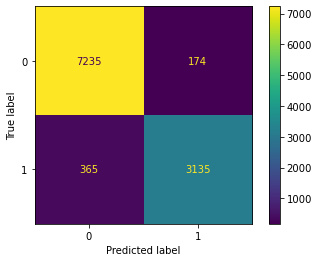

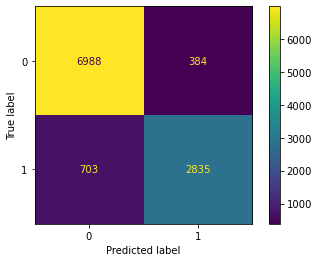

In [22]:
cm = confusion_matrix(y_train, dic_pred['train'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()

cm = confusion_matrix(y_test, dic_pred['test'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot()
plt.show()


In [23]:
impt = [rf_classifier.feature_importances_, np.std([tree.feature_importances_ for tree in rf_classifier.estimators_],axis=1)] 

ind = np.argsort(impt[0])


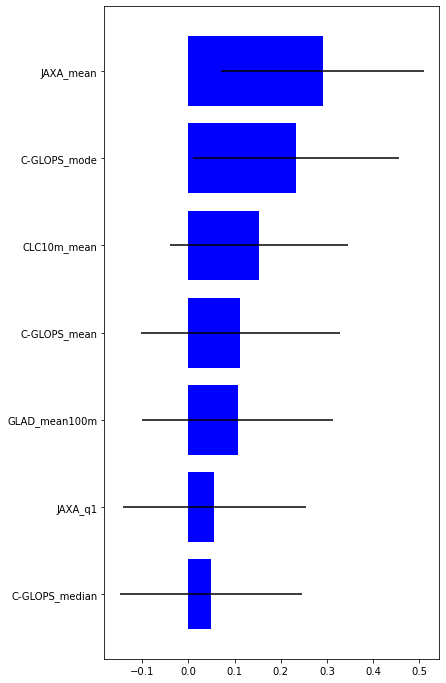

In [25]:
plt.rcParams["figure.figsize"] = (6,12)
plt.barh(range(len(pred_sel)),impt[0][ind],color="b", xerr=impt[1][ind], align="center")
plt.yticks(range(len(pred_sel)),feat[ind]);

predicting the tiff takes too long for this class so I am making a smaller map

In [23]:
GLAD_mean100m = "out_data/GLADGLCextent/reproj3035_100m_tifs/poland_mean100m.tif"
GLAD_median100m = "out_data/GLADGLCextent/reproj3035_100m_tifs/poland_median100m.tif"
GLAD_mode100m = "out_data/GLADGLCextent/reproj3035_100m_tifs/poland_mode100m.tif"
GLAD_q1 = "out_data/GLADGLCextent/reproj3035_100m_tifs/poland_q1.tif"
GLAD_q3 = "out_data/GLADGLCextent/reproj3035_100m_tifs/poland_q3.tif"
CLC10m_mean = "out_data/CLC10m/poland_mean.tif"
CLC10m_median = "out_data/CLC10m/poland_median.tif"
CLC10m_mode = "out_data/CLC10m/poland_mode.tif"
CLC10m_q1 = "out_data/CLC10m/poland_q1.tif"
CLC10m_q3 = "out_data/CLC10m/poland_q3.tif"
CLC_01 = "out_data/CLC/poland_01.vrt"
C_GLOPS_mean = "out_data/C-GLOPS/2019/poland_mean.tif"
C_GLOPS_median = "out_data/C-GLOPS/2019/poland_median.tif"
C_GLOPS_mode = "out_data/C-GLOPS/2019/poland_mode.tif"
C_GLOPS_q1 = "out_data/C-GLOPS/2019/poland_q1.tif"
C_GLOPS_q3 = "out_data/C-GLOPS/2019/poland_q3.tif"
JAXA_q3 = "out_data/JAXA/poland_q3.tif"
JAXA_q1 = "out_data/JAXA/poland_q1.tif"
JAXA_mode = "out_data/JAXA/poland_mode.tif"
JAXA_median = "out_data/JAXA/poland_median.tif"
JAXA_mean = "out_data/JAXA/poland_mean.tif"

In [24]:
pred_sel

['GLAD_mean100m',
 'JAXA_mean',
 'C-GLOPS_mode',
 'CLC10m_mean',
 'C-GLOPS_mean',
 'JAXA_q1',
 'C-GLOPS_median']

In [25]:
# predictors_rasters = [
#     GLAD_mean100m,
#     GLAD_median100m,
#     GLAD_mode100m,
#     GLAD_q1,
#     GLAD_q3,
#     CLC10m_mean,
#     CLC10m_median,
#     CLC10m_mode,
#     CLC10m_q1,
#     CLC10m_q3,
#    CLC_01,
#     C_GLOPS_mean,
#     C_GLOPS_median,
#     C_GLOPS_mode,
#     C_GLOPS_q1,
#     C_GLOPS_q3,
#     JAXA_q3,
#     JAXA_q1,
#     JAXA_mode,
#     JAXA_median,
#     JAXA_mean
# ]


predictors_rasters = [
    GLAD_mean100m, JAXA_mean, C_GLOPS_mode, CLC10m_mean, C_GLOPS_mean, JAXA_q1, C_GLOPS_median
]


In [26]:
print(predictors_rasters)
stack = Raster(predictors_rasters)

['out_data/GLADGLCextent/reproj3035_100m_tifs/poland_mean100m.tif', 'out_data/JAXA/poland_mean.tif', 'out_data/C-GLOPS/2019/poland_mode.tif', 'out_data/CLC10m/poland_mean.tif', 'out_data/C-GLOPS/2019/poland_mean.tif', 'out_data/JAXA/poland_q1.tif', 'out_data/C-GLOPS/2019/poland_median.tif']


In [27]:
stack

Raster Object Containing 7 Layers
    attribute                                             values
0       names  [poland_mean100m, poland_mean_1, poland_mode, ...
1       files  [out_data/GLADGLCextent/reproj3035_100m_tifs/p...
2        rows                                               6060
3        cols                                               7120
4         res                                     (100.0, 100.0)
5  nodatavals         [48.0, 48.0, 48.0, 48.0, 48.0, 48.0, 48.0]


In [130]:
result = stack.predict(estimator=rf_classifier, dtype='int16', nodata=-1)

In [138]:
output_path = "out_data/predictions/poland_small_RFprediction_test.tif"
result.write(output_path)

Raster Object Containing 1 Layers
    attribute                                             values
0       names                                       [pred_raw_0]
1       files  [out_data/predictions/poland_small_RFpredictio...
2        rows                                               6060
3        cols                                               7120
4         res                                     (100.0, 100.0)
5  nodatavals                                         [-32768.0]


In [139]:
!gdalinfo out_data/predictions/poland_small_RFprediction_test.tif

Driver: GTiff/GeoTIFF
Files: out_data/predictions/poland_small_RFprediction_test.tif
Size is 7120, 6060
Coordinate System is:
PROJCRS["ETRS89-extended / LAEA Europe",
    BASEGEOGCRS["ETRS89",
        ENSEMBLE["European Terrestrial Reference System 1989 ensemble",
            MEMBER["European Terrestrial Reference Frame 1989"],
            MEMBER["European Terrestrial Reference Frame 1990"],
            MEMBER["European Terrestrial Reference Frame 1991"],
            MEMBER["European Terrestrial Reference Frame 1992"],
            MEMBER["European Terrestrial Reference Frame 1993"],
            MEMBER["European Terrestrial Reference Frame 1994"],
            MEMBER["European Terrestrial Reference Frame 1996"],
            MEMBER["European Terrestrial Reference Frame 1997"],
            MEMBER["European Terrestrial Reference Frame 2000"],
            MEMBER["European Terrestrial Reference Frame 2005"],
            MEMBER["European Terrestrial Reference Frame 2014"],
            ELLIPSOI

In [26]:
# plot regression result
plt.rcParams["figure.figsize"] = (12,12)
result.iloc[0].cmap = "plasma"
stack.poland_mean100m.plot()
plt.show()

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [145]:
# todo, also get a predict_proba() map
result_probs = stack.predict_proba(estimator=rf_classifier)


In [146]:
output_path2 = "out_data/predictions/poland_small_RFprobs_test.tif"
result_probs.write(output_path2)

Raster Object Containing 2 Layers
    attribute                                             values
0       names                                   [prob_0, prob_1]
1       files  [out_data/predictions/poland_small_RFprobs_tes...
2        rows                                               6060
3        cols                                               7120
4         res                                     (100.0, 100.0)
5  nodatavals  [-3.4028234663852886e+38, -3.4028234663852886e...
